# Mercedes-Benz Kaggle Competition
The purpose of this set of notebooks is to model time (in seconds) a car took to pass testing for the set of nearly 400 anonymized covariates.

In [1]:
# Obligatory
options(stringsAsFactors = FALSE)
suppressWarnings(suppressMessages({
    library(dplyr)
    library(ggplot2)
}))

In [2]:
train <- read.csv('../data/train.csv')
test <- read.csv('../data/test.csv')

### Some brief checks to view the data and make sure they're "clean"

In [3]:
# Data set isn't very tall - but it's fat.
dim(train) %>% print
dim(test) %>% print

[1] 4209  378
[1] 4209  377


In [4]:
# Data have same set of features, except testing is missing response
setdiff(colnames(train), colnames(test)) %>% print
setdiff(colnames(test), colnames(train)) %>% print

[1] "y"
character(0)


In [5]:
# Check for missing data - there are none.
any(sapply(train, function(x) any(is.na(x)))) %>% print
any(sapply(test, function(x) any(is.na(x)))) %>% print

[1] FALSE
[1] FALSE


In [6]:
# Check that the ID variable is a unique identifier
(length(unique(train$ID)) == nrow(train)) %>% print
(length(unique(test$ID)) == nrow(test)) %>% print

[1] TRUE
[1] TRUE


In [7]:
# Let's just grab a head view of the data
head(train[c(1:6, 100:105)])

,ID,y,X0,X1,X2,X3,X101,X102,X103,X104,X105,X106
1,0,130.81,k,v,at,a,0,0,0,0,0,0
2,6,88.53,k,t,av,e,1,0,0,0,0,0
3,7,76.26,az,w,n,c,1,0,0,0,0,0
4,9,80.62,az,t,n,f,1,0,0,0,0,0
5,13,78.02,az,v,n,f,1,0,0,0,0,0
6,18,92.93,t,b,e,c,1,0,1,0,0,0


### EDA on categorical variables
It appears that we have a few categorical variables and several quantitative ones.  I'll dig into the categorical ones here first.

In [8]:
# Peel off covariates, grab categorical ones
covars <- train %>% select(starts_with('X'))
cat_names <- colnames(covars)[sapply(covars, function(x) class(x) == 'character')]
cat_vars_train <- train[cat_names]
cat_vars_test <- test[cat_names]
head(cat_vars_train)

,X0,X1,X2,X3,X4,X5,X6,X8
1,k,v,at,a,d,u,j,o
2,k,t,av,e,d,y,l,o
3,az,w,n,c,d,x,j,x
4,az,t,n,f,d,x,l,e
5,az,v,n,f,d,h,d,n
6,t,b,e,c,d,g,h,s


In [9]:
# Uh oh - X0, X2, and X5 each have levels in testing that are not in training
# Likely solution: Will make two models.  One with and one without X0, X2, and X5.
sapply(cat_vars_train, function(x) length(unique(x))) %>% print
sapply(cat_vars_test, function(x) length(unique(x))) %>% print

X0 X1 X2 X3 X4 X5 X6 X8 
47 27 44  7  4 29 12 25 
X0 X1 X2 X3 X4 X5 X6 X8 
49 27 45  7  4 32 12 25 


### EDA on quantitative variables
Most of our variables are quantitative, and as we will soon see, they are all binary!

In [10]:
num_names <- colnames(covars)[sapply(covars, function(x) class(x) != 'character')]
num_vars_train <- train[num_names]
num_vars_test <- test[num_names]

In [11]:
# All variables are binary!
table(sapply(num_vars_train, function(x) length(unique(x)))) %>% print

# Furthermore - many are unary!  Will need to remove these for model fitting
summary(sapply(num_vars_train, function(x) length(unique(x)))) %>% print


  1   2 
 12 356 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   2.000   1.967   2.000   2.000 


### EDA on response
Our response variable is quantitative and represents a length of time.

In [12]:
# Load package for plot scaling, and set options
library(repr)
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 120)

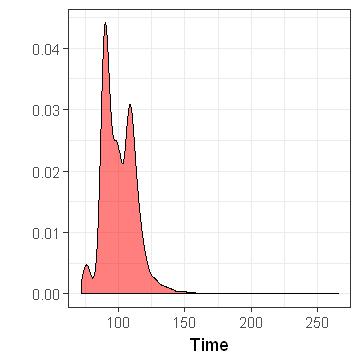

In [13]:
# Interesting trimodal(?) distribution
ggplot(train) +
    theme_bw() +
    geom_density(aes(y), fill = 'red', alpha = 1/2) +
    labs(x = 'Time', y = '')

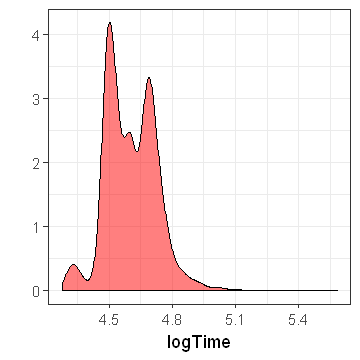

In [14]:
# Looks a little more symmetric on the log scale.  Will use this in my model.  However, data are still problematically trimodal.
ggplot(train) +
    theme_bw() +
    geom_density(aes(log(y)), fill = 'red', alpha = 1/2) +
    labs(x = 'logTime', y = '')

# Conclusions
We have 8 categorical variables, some with over 40 levels.  We also have hundreds of binary variables.  To me, this screams _tree methods, you idiot!_, but there are two problems with tree methods:
* I have an extreme curse of dimensionality (maybe not that big of a problem...)
* Everyone on Kaggle is probably just going to XGBoost the hell out of this, and I want to be different.

I believe that this is an excellent opportunity to use a [grouped lasso](http://pages.stat.wisc.edu/~myuan/papers/glasso.final.pdf).  The advantage to this technique is that I can group the indicator matrices produced by the categorical variables so that they are all regularized to zero simultaneously.  This way, I can regularize my model to prevent overfitting, while still appropriately dealing with the categorical variables.  The binary variables need not be grouped in this way.  In addition, I will also be using the log response.